# Posterior Predictive Checks (PPC) for S0, S1, S2, SSNND\_med

This notebook draws posterior samples from the **final ABC population** in your SQLite `.db` and generates posterior predictive bands for the summary statistics: **S0, S1, S2, SSNND\_med**. It overlays the observed series and saves CSV/PNG outputs.

**Requirements**:
- Your observed CSV must contain columns: `timestep, S0, S1, S2, SSNND_med` (this matches the updated runner and simulator).
- The ABC run was executed with the updated scripts, which simulate and compare these exact stats. citeturn18file68turn18file64

> If your observed CSV still has `avg_nnd_median_px` (centroid NND), please convert it to `SSNND_med` before running. citeturn18file68


In [27]:
# --- Imports ---
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyabc

# Project modules (adjust if your package path differs)
from abm.clusters_model import ClustersModel
from abcp.abc_model_wrapper import particle_to_params
from abcp.compute_summary import simulate_timeseries

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 140


## Configure paths and options
Update the variables below to point to your ABC results DB and observed CSV.


In [28]:
# --- User configuration ---
DB_PATH = 'results/abc_persistent_lognorm_init_test_1000_12.db'          # path to SQLite DB produced by run_abc_maxabs_sweep.py
OBSERVED_CSV = 'observed/INV_ABM_ss_nnd.csv'  # observed time-series
MOTION = 'persistent'                        # 'isotropic' or 'persistent' (used for re-sim)
SPEED_DIST = 'lognorm'                     # 'constant','lognorm','gamma','weibull' (used for re-sim)
TOTAL_STEPS = 100                           # total ABM steps used during ABC
N_DRAWS = 1000                               # posterior draws for PPC re-simulation
OUTDIR = Path('results/PPC')                # output folder for CSVs/PNGs

# --- Ensure output directory exists ---
OUTDIR.mkdir(parents=True, exist_ok=True)
print('Outputs will be saved in:', OUTDIR.resolve())


Outputs will be saved in: /Users/nathan/Documents/Oxford/DPhil/mesa_abm/abc_ss_nnd/results/PPC


## Load observed time-series (expects S0, S1, S2, SSNND\_med)


In [29]:
# Read observed
obs_df = pd.read_csv(OBSERVED_CSV)
required_cols = ['timestep','S0','S1','S2','SSNND_med']
missing = [c for c in required_cols if c not in obs_df.columns]
if missing:
    raise ValueError(f'Observed CSV missing columns: {missing}. Expected: {required_cols}')

obs_df = obs_df.sort_values('timestep').reset_index(drop=True)
timesteps = obs_df['timestep'].astype(int).tolist()
stats = ['S0','S1','S2','SSNND_med']
obs_mat = obs_df[stats].to_numpy(float)  # T x 4
T, K = obs_mat.shape
print(f'Loaded observed with T={T} timesteps and stats={stats}')


Loaded observed with T=53 timesteps and stats=['S0', 'S1', 'S2', 'SSNND_med']


## Load final ABC population and resimulate PPC
We re-simulate to obtain **raw (unscaled)** summary statistics for PPC visualisation. The updated runner stored scaled sum-stat vectors in the DB, so re-simulation avoids mixing scaled units with raw observed series. citeturn18file68


In [30]:
# Load posterior at final population
h = pyabc.History(f'sqlite:///{DB_PATH}')
t_max = h.max_t
params_df, w = h.get_distribution(m=0, t=t_max)
if len(params_df) == 0:
    raise RuntimeError('No posterior found. Did ABC finish at least one population?')
w = np.asarray(w, float)
w = w / w.sum() if w.sum() > 0 else np.ones_like(w)/len(w)
print(f'Final population t={t_max} with {len(params_df)} particles.')

# Weighted sampling of posterior particles
rng = np.random.default_rng(2026)
# idxs = rng.choice(np.arange(len(params_df)), size=min(N_DRAWS, len(params_df)), replace=False, p=w)
idxs = rng.choice(np.arange(len(params_df)), size=min(N_DRAWS, len(params_df)), replace=True, p=w)

# Re-simulate
factory = (lambda seed: (lambda params_dict: ClustersModel(params=params_dict, seed=seed)))
model_factory = factory(seed=777)
full_order = ['S0','S1','S2','SSNND_med']  # simulator output order (updated) citeturn18file64
col_idx = [full_order.index(s) for s in stats]

sims = []  # N x T x K
for i in idxs:
    p = params_df.iloc[i].to_dict()
    params = particle_to_params(p, motion=MOTION, speed_dist=SPEED_DIST)
    sim_full = simulate_timeseries(model_factory, params, total_steps=TOTAL_STEPS, sample_steps=tuple(timesteps))
    sims.append(sim_full[:, col_idx])
sims = np.asarray(sims)
print('Simulated PPC draws:', sims.shape)


Final population t=11 with 1000 particles.
Simulated PPC draws: (1000, 53, 4)


In [31]:

# Summarise bands
med = np.median(sims, axis=0)
q05 = np.quantile(sims, 0.025, axis=0)
q95 = np.quantile(sims, 0.975, axis=0)
t = np.array(timesteps)

# Save CSVs
for k, s in enumerate(stats):
    pd.DataFrame(med[:, k], columns=[s]).to_csv(OUTDIR / f'ppc_ts_median_{s}.csv', index=False)
    pd.DataFrame(q05[:, k], columns=[s]).to_csv(OUTDIR / f'ppc_ts_q05_{s}.csv', index=False)
    pd.DataFrame(q95[:, k], columns=[s]).to_csv(OUTDIR / f'ppc_ts_q95_{s}.csv', index=False)
print('Saved PPC CSVs to:', OUTDIR)


Saved PPC CSVs to: results/PPC


## Plot PPC bands and overlays (saved to PNG + shown inline)


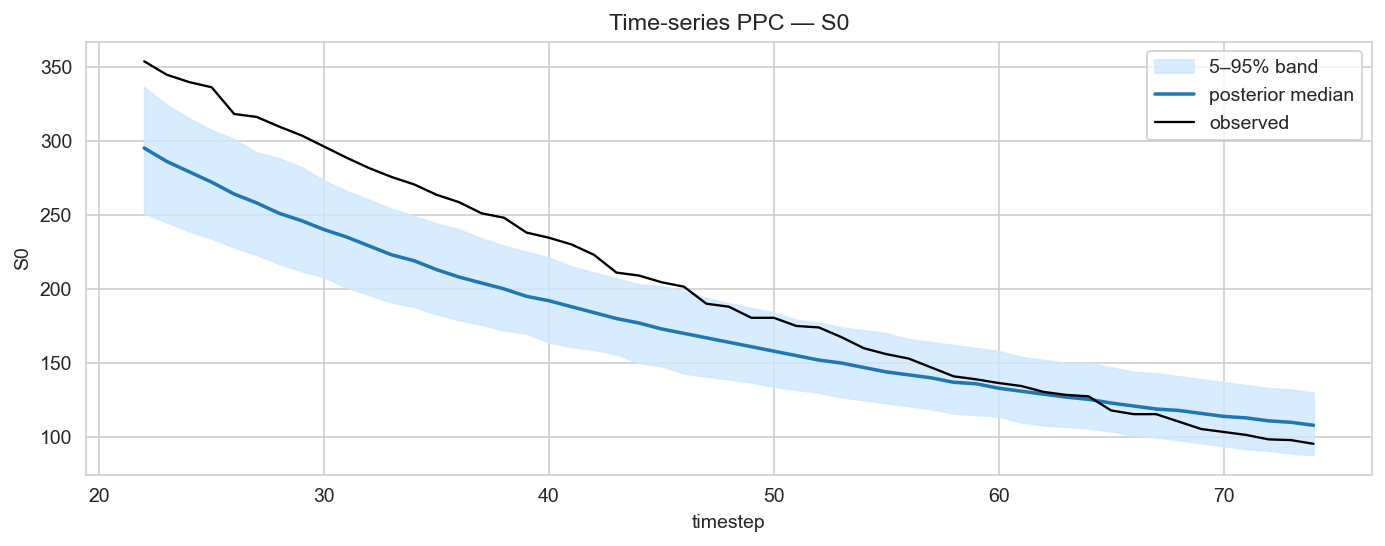

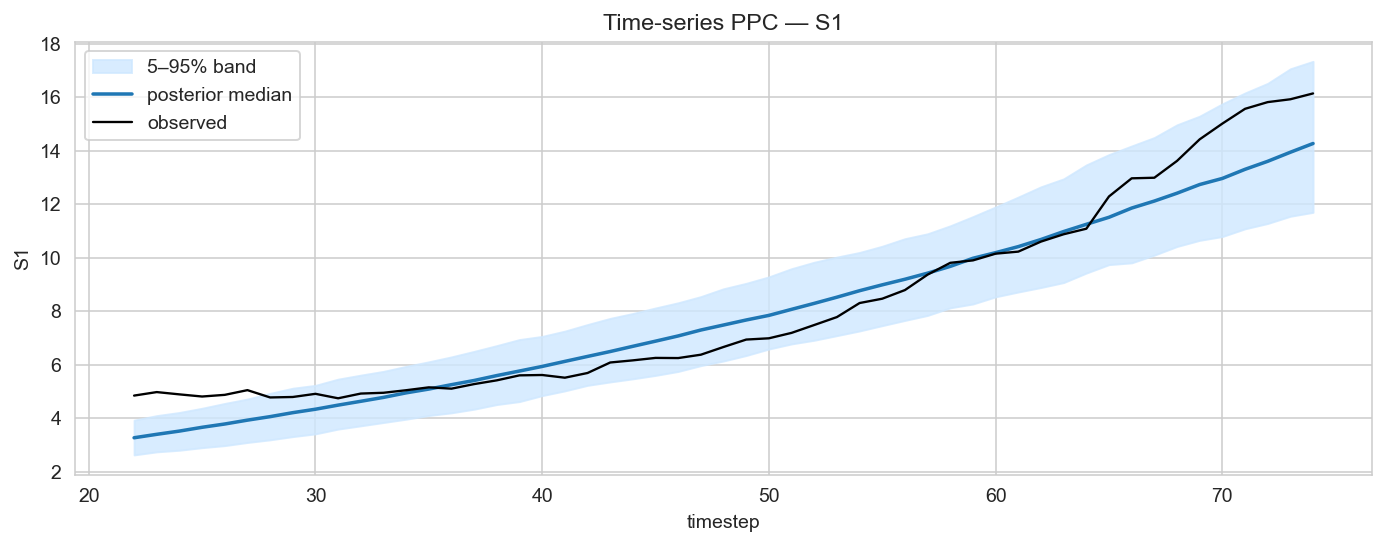

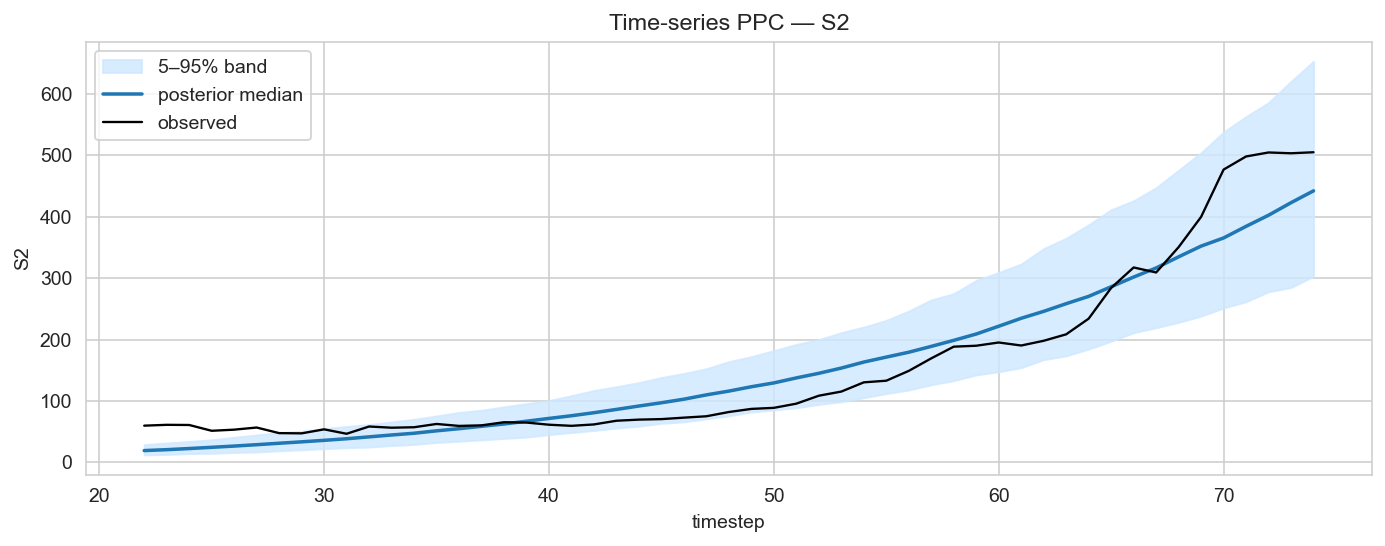

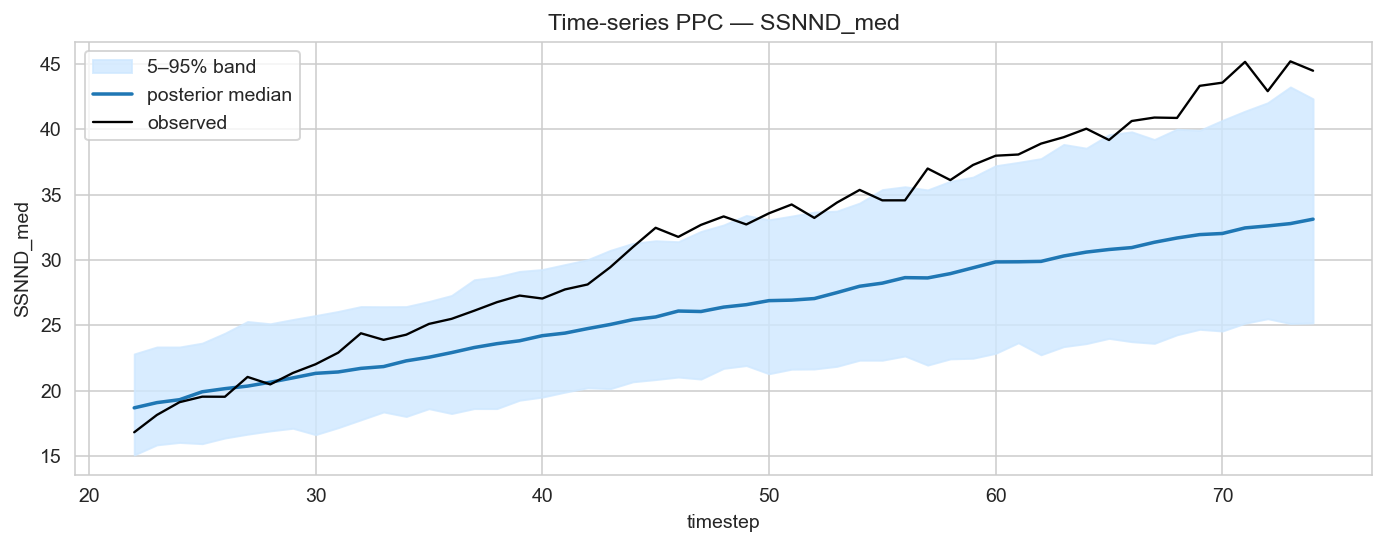

Saved PPC PNGs to: results/PPC


In [32]:
for k, s in enumerate(stats):
    plt.figure(figsize=(10, 4))
    plt.fill_between(t, q05[:, k], q95[:, k], color='#cfe8ff', alpha=0.8, label='5–95% band')
    plt.plot(t, med[:, k], color='#1f77b4', lw=1.8, label='posterior median')
    plt.plot(t, obs_mat[:, k], color='black', lw=1.2, label='observed')
    plt.xlabel('timestep')
    plt.ylabel(s)
    plt.title(f'Time-series PPC — {s}')
    plt.legend()
    plt.tight_layout()
    out_png = OUTDIR / f'ppc_ts_{s}.png'
    plt.savefig(out_png)
    plt.show()
print('Saved PPC PNGs to:', OUTDIR)


## Discrepancy over time
Median Euclidean discrepancy across the selected stats.


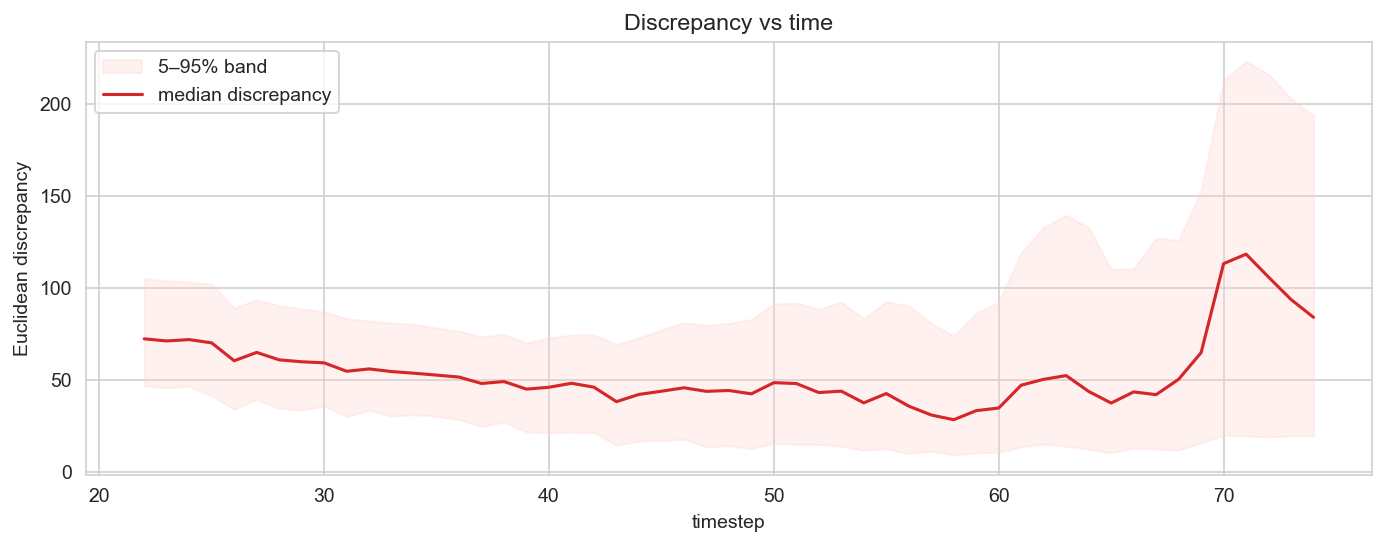

Saved discrepancy CSV/PNG to: results/PPC


In [33]:
disc_per_draw = [np.sqrt(np.sum((sim - obs_mat)**2, axis=1)) for sim in sims]  # per timestep
disc_per_draw = np.asarray(disc_per_draw)
disc_med = np.median(disc_per_draw, axis=0)
disc_q05 = np.quantile(disc_per_draw, 0.05, axis=0)
disc_q95 = np.quantile(disc_per_draw, 0.95, axis=0)
pd.DataFrame({'timestep': t, 'disc_med': disc_med, 'disc_q05': disc_q05, 'disc_q95': disc_q95}).to_csv(OUTDIR / 'ppc_discrepancy.csv', index=False)

plt.figure(figsize=(10,4))
plt.fill_between(t, disc_q05, disc_q95, alpha=0.3, color='#ffd2cc', label='5–95% band')
plt.plot(t, disc_med, color='#d62728', lw=1.6, label='median discrepancy')
plt.title('Discrepancy vs time')
plt.xlabel('timestep')
plt.ylabel('Euclidean discrepancy')
plt.legend()
plt.tight_layout()
plt.savefig(OUTDIR / 'ppc_discrepancy.png')
plt.show()
print('Saved discrepancy CSV/PNG to:', OUTDIR)
